## Variational AutoEncoder

- The VQ-VAE uses a discrete latent representation.
- Many important real-world objects are discrete. 



## Loss

The total loss is actually composed of three components

1. **reconstruction loss**: which optimizes the decoder and encoder
2. **KL divergence loss**: for unit norm bounding

In [1]:
!printf "torch\ntorchvision\nmatplotlib\nnumpy==1.23.0\nscipy\nsix\numap-learn\n" > "requirements.txt"
!cat requirements.txt
!pip3 install -U -r requirements.txt

torch
torchvision
matplotlib
numpy==1.23.0
scipy
six
umap-learn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange

import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

In [4]:
training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

validation_data = datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [5]:
data_variance = np.var(training_data.data / 255.0)

## Encoder & Decoder Architecture

The encoder and decoder architecture is based on a ResNet and is implemented below:

In [6]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [252]:
class VariationalEncoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(VariationalEncoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        
        self._residual_stack_1 = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._residual_stack_2 = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._flatten1 = nn.Flatten(start_dim=1)
        self._flatten2 = nn.Flatten(start_dim=1)
        self._unflatten = nn.Unflatten(1, (128, 8, 8))
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)

        mu =  self._flatten1(self._residual_stack_1(x))
        sigma = self._flatten2(torch.exp(self._residual_stack_2(x.clone())))

        # sample and return
        embedding = self._unflatten(mu + sigma*self.N.sample(mu.shape))

        # mu =  self._residual_stack_1(x)
        # sigma = torch.exp(self._residual_stack_2(x.clone()))

        # # sample and return
        # embedding = mu + sigma*self.N.sample(mu.shape)
        # print(embedding.shape)
        
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        kl_loss = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()

        return embedding, kl_loss

In [261]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=3,
                                                kernel_size=4, 
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        
        x = self._residual_stack(x)
        
        x = self._conv_trans_1(x)
        x = F.relu(x)
        
        return self._conv_trans_2(x)

## Train

We use the hyperparameters from the paper authors.

In [291]:
batch_size = 256
num_training_updates = 3500

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

learning_rate = 1e-5

In [292]:
training_loader = DataLoader(training_data, 
                             batch_size=batch_size, 
                             shuffle=True,
                             pin_memory=True)

In [293]:
validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)

In [294]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, decay=0):
        super(Model, self).__init__()
        
        self._encoder = VariationalEncoder(3, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        
        self._intermediate_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens)
      

    def forward(self, x):
        z, kl_loss = self._encoder(x)
        z = self._intermediate_conv(z)
        x_recon = self._decoder(z)
        return x_recon, kl_loss

In [295]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim).to(device)
print(model)

Model(
  (_encoder): VariationalEncoder(
    (_conv_1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack_1): ResidualStack(
      (_layers): ModuleList(
        (0): Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
        (1): Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
     

In [296]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [297]:
import torch
torch.autograd.set_detect_anomaly(True)

model.train()
train_res_recon_error = []
train_res_kl_divergence = []

for i in xrange(num_training_updates):
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()

    data_recon, kl_loss = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance

    # Accumulate losses
    loss = recon_error + kl_loss
    loss.backward()

    optimizer.step()
    
    train_res_recon_error.append(recon_error.item())
    train_res_kl_divergence.append(kl_loss.item())

    if (i+1) % 50 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('kl_error: %.3f' % np.mean(train_res_kl_divergence[-100:]))
        print()

50 iterations
recon_error: 1.092
kl_error: 1069080.180

100 iterations
recon_error: 1.068
kl_error: 1062467.099

150 iterations
recon_error: 1.036
kl_error: 1053183.130

200 iterations
recon_error: 1.024
kl_error: 1049868.146

250 iterations
recon_error: 1.015
kl_error: 1049046.021

300 iterations
recon_error: 1.011
kl_error: 1048801.575

350 iterations
recon_error: 1.012
kl_error: 1048704.728

400 iterations
recon_error: 1.005
kl_error: 1048658.914

450 iterations
recon_error: 1.001
kl_error: 1048633.702

500 iterations
recon_error: 1.002
kl_error: 1048617.714

550 iterations
recon_error: 1.003
kl_error: 1048607.279

600 iterations
recon_error: 1.004
kl_error: 1048600.125

650 iterations
recon_error: 0.998
kl_error: 1048595.014

700 iterations
recon_error: 0.998
kl_error: 1048591.186

750 iterations
recon_error: 1.000
kl_error: 1048588.249

800 iterations
recon_error: 0.993
kl_error: 1048585.859

850 iterations
recon_error: 0.989
kl_error: 1048584.076

900 iterations
recon_error: 0.99

## Plot Loss

In [298]:
# Reduce plot noise using a smoothing filter (Savistky-Golay)
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_kl_error_smooth = savgol_filter(train_res_kl_divergence, 201, 7)

Text(0.5, 0, 'iteration')

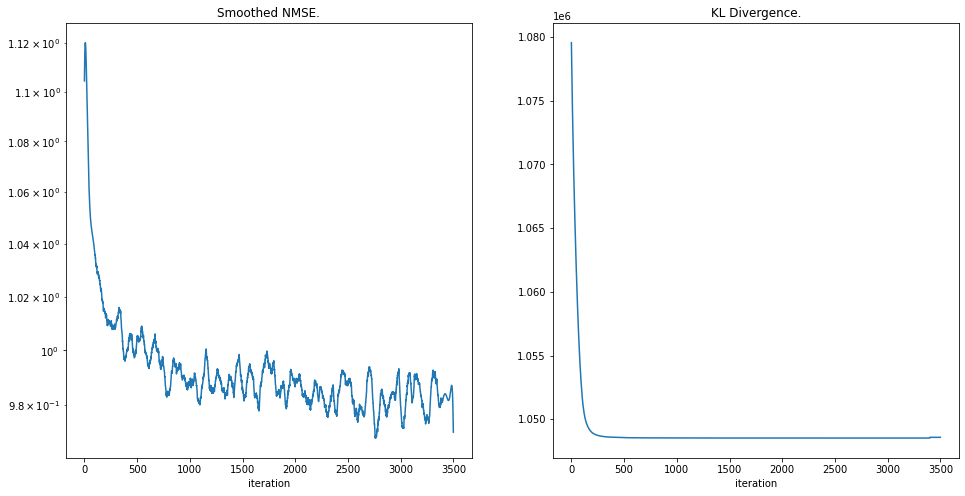

In [299]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_kl_error_smooth)
ax.set_title('KL Divergence.')
ax.set_xlabel('iteration')

## View Reconstructions

In [300]:
model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

x, _ = model._encoder(valid_originals)
encoder_op_eval = model._intermediate_conv(x)
valid_reconstructions = model._decoder(encoder_op_eval)

In [301]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

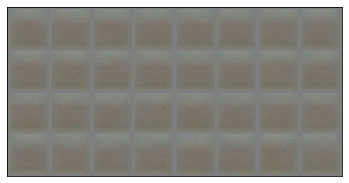

In [302]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

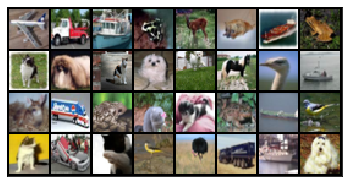

In [303]:
show(make_grid(valid_originals.cpu()+0.5))